In [10]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.external.tifffile import imread
import ipywidgets as widgets
from scipy.ndimage import gaussian_filter

In [11]:
mainDir=r'S:\CookLab\Liu\20190816_organizedData_MCM_loading\DATA'
cellsOrgFile=r'S:\CookLab\Liu\20190816_organizedData_MCM_loading\sel_cells_v1.csv'
cellsIndThreshFile=r'S:\CookLab\Liu\20190816_organizedData_MCM_loading\sel_cells_ind_threshold.csv'

## Read existing thresholds or generate new list

In [16]:
myCells=pd.read_csv(cellsOrgFile)

try:
    myData=pd.read_csv(cellsIndThreshFile)
    
except FileNotFoundError:
    
    myData=myCells.loc[:,['file','path','decon']]
    
    # randomly shuffle data
    myData=myData.sample(frac=1).reset_index(drop=True)
    myData['threshold']=None

In [17]:
# how many cells were already thresholded
i=np.sum(myData.threshold==myData.threshold)
print(f'Number of cells to threshold: {len(myData)-i}')

Number of cells to threshold: 94


## Display cells for thresholding

In [18]:
def update_image(stack,axes,idx):
    
    # find current axis limits
    xmin, xmax = plt.xlim()  
    ymin, ymax = plt.ylim()

    # display image
    axes[0].clear()
    img=axes[0].imshow(stack[idx,0,:,:],vmin=minDisplay,vmax=maxDisplay)
    img.set_cmap('gray')
    axes[0].set_axis_off()

    # display image
    axes[1].clear()
    img=axes[1].imshow((stack[idx,0,:,:]>thr),vmin=0,vmax=1)
    img.set_cmap('gray')
    axes[1].set_axis_off()
    
    if xmax>1:
        # set axis limits
        plt.xlim(xmin, xmax)   
        plt.ylim(ymin, ymax)     

    plt.show()
    
# position slider
def on_idx_change(change):

    global idx
    
    idx=idxPosition.value
    
    update_image(stack,axes,idx)

# display range slider
def on_value_change(change):

    global minDisplay
    global maxDisplay
    
    minDisplay=intRange.value[0]
    maxDisplay=intRange.value[1]
    
    update_image(stack,axes,idx)
    
# position slider
def on_thr_change(change):

    global thr
    
    thr=thrPosition.value
    
    update_image(stack,axes,idx)

# next button
def next_button_clicked(b):
    
    global i
    global stack
    global myData
    global thrPosition
    global intRange
    global idxPosition
    global idx
    
    if (i>=len(myData)):
        
        # end of the series riched
        print('Done')
        
    else:
        
        progBar.value += 1
    
    myData.loc[i,'threshold']=thr
    myData.to_csv(cellsIndThreshFile)
    
    i=i+1

    if (i<len(myCells)):
        
        stack=imread(myData.path[i])
        stack=gaussian_filter(stack, sigma=1)
          
        myMax=np.max(stack)
        myMin=np.min(stack)
        thrPosition.max = myMax
        thrPosition.min = myMin
        intRange.max = myMax
        intRange.min = myMin
        idxPosition.max=stack.shape[0]-1
        idx = int((stack.shape[0]-1)/2)
        idxPosition.value=idx
        
        update_image(stack,axes,idx)



<IPython.core.display.Javascript object>


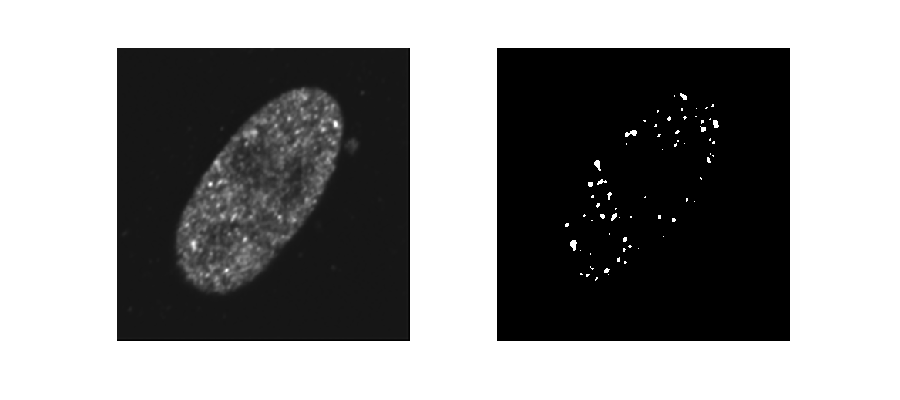

IntSlider(value=0, description='Position:', max=46)

IntRangeSlider(value=(557, 37206), description='Intensity:', layout=Layout(width='90%'), max=37206)

IntSlider(value=0, description='Threshold:', layout=Layout(width='90%'), max=37206)

Button(description='Next', style=ButtonStyle())

IntProgress(value=278, description='Progress:', max=300)

Done


In [25]:
%matplotlib notebook

idx=0
thr=0

stack=imread(myData.path[i])
stack=gaussian_filter(stack, sigma=1)

movieLen=stack.shape[0]-1
minDisplay=np.min(stack)
maxDisplay=np.max(stack)

fig,axes=plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,figsize=[9,4])

update_image(stack,axes,idx)

idxPosition = widgets.IntSlider(min=0, max=movieLen, value=0, description='Position:')
display(idxPosition)
idxPosition.observe(on_idx_change, names='value')

# intensity slider
intRange=widgets.IntRangeSlider(
    value=[minDisplay, maxDisplay],
    min=0,
    max=np.max(stack),
    step=1,
    description='Intensity:',
    layout=widgets.Layout(width='90%')
)
display(intRange)
intRange.observe(on_value_change, names='value')

# threshold slider
thrPosition = widgets.IntSlider(min=0, max=np.max(stack), value=thr, description='Threshold:',
                               layout=widgets.Layout(width='90%'))
display(thrPosition)
thrPosition.observe(on_thr_change, names='value')

# next button
nextButton=widgets.Button(description="Next")
display(nextButton)
nextButton.on_click(next_button_clicked)

# progress bar
progBar=widgets.IntProgress(
    value=i,
    min=0,
    max=len(myData),
    step=1,
    description='Progress:',
    orientation='horizontal'
)
display(progBar)